In [42]:
import gc
from collections import Counter

import pandas as pd
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

In [2]:
fred = pd.read_csv(r"./data/FRED/FRED3_Entire_Database_2021.csv", low_memory=False, header=0, skiprows=range(1, 10), encoding="latin1")
meta = pd.read_csv(r"./data/FRED/FRED3_Column_Definitions_2021.csv", usecols=["column_id", "name", "units"], index_col="column_id")
lookup = pd.read_csv(r"./data/plantlookup.csv", low_memory=False, encoding="latin1", index_col=0)

In [3]:
COLLABORATION_GRADIENT_TRAITS = [
    "F00679", # RD
    "F00727", # SRL
    "F00718", #	Specific root area (SRA)
    "F00104", # RCT
    "F00622", # Mycorrhiza_Fraction root length colonized by AM mycorrhizae
    "F00626", # Mycorrhiza_Fraction root length colonized by EM mycorrhizae
    "F00638", # Mycorrhiza_Fraction of root length
    "F00645"  # Mycorrhiza_Type_Data
]

CONSERVATION_GRADIENT_TRAITS = [
    "F00709", # RTD
    "F00277", #	Root P content
    "F00261", # Root N content
    "F00358"  # Root lignin content
]

In [4]:
# meta[meta.name.str.contains("taxonomy")]

In [60]:
# TO AVOID TAXONOMIC CONFLICTS, WE'LL FILL IN FRED WITH FAMILY AND ORDER INFO USING THE LOOKUP TABLE!
# EVEN IF FRED ALREADY CONTAINS THESE INFO FOR CERTAIN RECORDS

lookup

family        order          group
genus                                                  
Acorus            Acoraceae     Acorales    Angiosperms
Albidella      Alismataceae  Alismatales    Angiosperms
Alisma         Alismataceae  Alismatales    Angiosperms
Astonia        Alismataceae  Alismatales    Angiosperms
Baldellia      Alismataceae  Alismatales    Angiosperms
...                     ...          ...            ...
Ugena           Lygodiaceae  Schizaeales  Pteridophytes
Actinostachys  Schizaeaceae  Schizaeales  Pteridophytes
Lophidium      Schizaeaceae  Schizaeales  Pteridophytes
Microschizaea  Schizaeaceae  Schizaeales  Pteridophytes
Schizaea       Schizaeaceae  Schizaeales  Pteridophytes

[23279 rows x 3 columns]

In [83]:
fred.shape

(57190, 1164)

In [6]:
# root traits of interest - 
# F00056 - root order

fred.loc[:, ["F00018", "F00019", "F00056"] + COLLABORATION_GRADIENT_TRAITS + 
                    CONSERVATION_GRADIENT_TRAITS].query("F00056.isin((1, 2, 3))")  # only choosing 1st, 2nd and 3rd order roots

F00018      F00019  F00056    F00679  F00727  F00718  F00104  \
0      Dicranopteris   dichotoma     1.0       NaN     NaN     NaN     NaN   
1      Dicranopteris   dichotoma     2.0       NaN     NaN     NaN     NaN   
2      Dicranopteris   dichotoma     3.0       NaN     NaN     NaN     NaN   
3       Cunninghamia  lanceolata     1.0       NaN     NaN     NaN     NaN   
4       Cunninghamia  lanceolata     2.0       NaN     NaN     NaN     NaN   
...              ...         ...     ...       ...     ...     ...     ...   
57145         Vitis     vinifera     2.0  0.175183  0.0125     NaN     NaN   
57146         Vitis     vinifera     3.0  0.260983  0.0087     NaN     NaN   
57149         Vitis     vinifera     1.0  0.162800  0.0591     NaN     NaN   
57150         Vitis     vinifera     2.0  0.213133  0.0214     NaN     NaN   
57151         Vitis     vinifera     3.0  0.310233  0.0079     NaN     NaN   

          F00622  F00626  F00638 F00645  F00709  F00277  F00261  F00358  
0            NaN     NaN     NaN     AM     NaN     NaN     NaN     NaN  
1            NaN     NaN     NaN     AM     NaN     NaN     NaN     NaN  
2            NaN     NaN     NaN     AM     NaN     NaN     NaN     NaN  
3            NaN     NaN     NaN     AM     NaN     NaN     NaN     NaN  
4            NaN     NaN     NaN     AM     NaN     NaN     NaN     NaN  
...          ...     ...     ...    ...     ...     ...     ...     ...  
57145  53.333333     NaN     NaN    NaN     NaN     NaN     NaN     NaN  
57146  31.666667     NaN     NaN    NaN     NaN     NaN     NaN     NaN  
57149  56.666667     NaN     NaN    NaN     NaN     NaN     NaN     NaN  
57150  51.666667     NaN     NaN    NaN     NaN     NaN     NaN     NaN  
57151  46.666667     NaN     NaN    NaN     NaN     NaN     NaN     NaN  

[5557 rows x 15 columns]

In [7]:
fred.loc[:, ["F00018", "F00019", "F00056"] + COLLABORATION_GRADIENT_TRAITS + CONSERVATION_GRADIENT_TRAITS].\
    query("F00056.isin((1, 2, 3))").isna().mean()

F00018    0.036351
F00019    0.070182
F00056    0.000000
F00679    0.325535
F00727    0.704877
F00718    0.959690
F00104    0.950693
F00622    0.992442
F00626    0.999640
F00638    0.993702
F00645    0.791794
F00709    0.780997
F00277    0.976606
F00261    0.716394
F00358    1.000000
dtype: float64

In [ ]:
# root diamater and specific root length !!!!!!!!

In [6]:
FRED_MISSPELT_GENERA = { # TF?????
     "Aglaria": "Aglaia",
     "Aporusa": "Aporosa",
     "Artrocarpus": "Artocarpus",
     "Atrocarpus": "Artocarpus",
     "Brosimun": "Brosimum",
     "Diospyrus": "Diospyros",
     "Gletitsia": "Gleditsia",
     "Parakmeria": "Magnolia", # synonym for Magnolia lotungensis
     "Paramichelia": "Magnolia", # synonym for Magnolia baillonii
     "Polyanthia": "Polyalthia",
     "Tabebuis": "Tabebuia",
     "Tabernamontana": "Tabernaemontana"
}

LOOKUP_MISSING_GENERA = {
    "Carrizo": "Rutaceae",
    "Cuoropita": "Lecythidaceae",
    "Tsoongiodendron": "Magnoliaceae",
    "Schizonepeta": "Lamiaceae",
    "Schyzolobium": "Fabaceae",
    "Swingle": "Rutaceae",
    "x Citrofortunella": "Rutaceae"
}

In [61]:
np.where(np.concatenate([lookup.family.values, list(LOOKUP_MISSING_GENERA.values())])

array(['Acoraceae', 'Alismataceae', 'Alismataceae', ..., 'Fabaceae',
       'Rutaceae', 'Rutaceae'], shape=(23286,), dtype=object)

In [7]:
FAMILY_LOOKUP_TABLE = pd.DataFrame(
    index=np.concatenate([lookup.index.values, list(LOOKUP_MISSING_GENERA.keys())]),
    data=[
        np.concatenate([lookup.family.values, list(LOOKUP_MISSING_GENERA.values())]),
        
         ]
)

In [8]:
FAMILY_LOOKUP_TABLE

Acorus                  Acoraceae
Albidella            Alismataceae
Alisma               Alismataceae
Astonia              Alismataceae
Baldellia            Alismataceae
                         ...     
Tsoongiodendron      Magnoliaceae
Schizonepeta            Lamiaceae
Schyzolobium             Fabaceae
Swingle                  Rutaceae
x Citrofortunella        Rutaceae
Length: 23286, dtype: object

In [9]:
[gc.collect(_) for _ in range(0, 3)]

[0, 0, 0]

## ___Root diameter___
----------------------

In [10]:
fred_fine_root_diameter = fred.loc[:, ["F00017", "F00018", "F00019", "F00056", "F00679", "F01290"]].\
                                    query("F00056.isin((1, 2, 3))").dropna(subset=["F00018", "F00679"])

# strip off the trailing or preceding whitespaces
fred_fine_root_diameter.F00018 = fred_fine_root_diameter.F00018.str.strip()

# spelling correction
fred_fine_root_diameter.F00018 = fred_fine_root_diameter.F00018.apply(lambda genus:\
                                     FRED_MISSPELT_GENERA.get(genus) if\
                                         FRED_MISSPELT_GENERA.get(genus, None) else genus)

# update the family info
fred_fine_root_diameter.F00017 = FAMILY_LOOKUP_TABLE[fred_fine_root_diameter.F00018].values

In [11]:
fred_fine_root_diameter.isna().sum() # F00019 is the species name, so that's alright for now

F00017      0
F00018      0
F00019    183
F00056      0
F00679      0
F01290      0
dtype: int64

In [12]:
fred_fine_root_diameter.groupby(["F01290", "F00017", "F00018"]).count().loc[:, "F00679"]

F01290         F00017          F00018         
Apiales        Apiaceae        Sanicula            1
               Araliaceae      Dendropanax         1
                               Eleutherococcus     1
                               Macropanax          1
                               Schefflera          2
                                                  ..
Zingiberales   Musaceae        Musa               60
               Zingiberaceae   Alpinia             1
                               Amomum              1
Zygophyllales  Zygophyllaceae  Bulnesia            1
                               Guaiacum            1
Name: F00679, Length: 318, dtype: int64

In [13]:
fred_fine_root_diameter.groupby(["F01290", "F00017", "F00018"]).count().loc[:, "F00679"]

F01290         F00017          F00018         
Apiales        Apiaceae        Sanicula            1
               Araliaceae      Dendropanax         1
                               Eleutherococcus     1
                               Macropanax          1
                               Schefflera          2
                                                  ..
Zingiberales   Musaceae        Musa               60
               Zingiberaceae   Alpinia             1
                               Amomum              1
Zygophyllales  Zygophyllaceae  Bulnesia            1
                               Guaiacum            1
Name: F00679, Length: 318, dtype: int64

In [14]:
# orders, families and genera
print(
    fred_fine_root_diameter.F01290.unique().size,
    fred_fine_root_diameter.F00017.unique().size,
    fred_fine_root_diameter.F00018.unique().size
)

45 111 314


In [15]:
# AS IT SHOULD BE
sum([df.shape[0] for (_, df) in fred_fine_root_diameter.groupby("F01290")]), \
    sum([df.shape[0] for (_, df) in fred_fine_root_diameter.groupby("F00017")]), \
        sum([df.shape[0] for (_, df) in fred_fine_root_diameter.groupby("F00018")])

(3674, 3674, 3674)

In [16]:
fred_fine_root_diameter_taxonomy = fred_fine_root_diameter.loc[:, ["F01290", "F00017", "F00018", "F00019"]
    ].sort_values(by=["F01290", "F00017", "F00018", "F00019"])

In [24]:
fred_fine_root_diameter_taxonomy.isna().sum()

F01290      0
F00017      0
F00018      0
F00019    183
dtype: int64

In [21]:
fred_fine_root_diameter_taxonomy.F01290.value_counts(sort=False)

F01290
Apiales             6
Aquifoliales        4
Arecales          122
Asparagales        65
Asterales          29
Boraginales         4
Brassicales         2
Caryophyllales     21
Celastrales        12
Chloranthales       3
Cornales           27
Cucurbitales        1
Cupressales         6
Cyatheales          1
Dipsacales         64
Discoreales         1
Equisetales         6
Ericales          208
Fabales            47
Fagales           241
Gentianales        87
Ginkgoales          3
Gleicheniales       7
Icacinales          3
Lamiales          198
Laurales          199
Liliales            3
Magnoliales       177
Malpighiales      119
Malvales           91
Myrtales          143
Osmundales          1
Oxalidales          9
Pinales           458
Poales             89
Polypodiales       28
Proteales           5
Ranunculales       11
Rosales           458
Santalales          1
Sapindales        489
Saxifragales      149
Vitales            12
Zingiberales       62
Zygophyllales       2
Nam

In [20]:
fred_fine_root_diameter_taxonomy.F00017.value_counts(sort=False)

F00017
Apiaceae            1
Araliaceae          5
Aquifoliaceae       4
Arecaceae         122
Amaryllidaceae     13
                 ... 
Saxifragaceae       2
Vitaceae           12
Musaceae           60
Zingiberaceae       2
Zygophyllaceae      2
Name: count, Length: 111, dtype: int64

In [62]:
# NO ONE ASKED NP.UNIQUE TO SORT THE RETURN VALUES! TF?
# families, family_freq = np.unique(fred_fine_root_diameter_taxonomy.F00017, return_counts=True)
# THIS WON'T WORK!!! AS THE ORDER OF THE INPUT IS NOT PRESERVED IN THE RETURNED ARRAY????

In [50]:
fred_fine_root_diameter_taxonomy.F01290.unique()

array(['Apiales', 'Aquifoliales', 'Arecales', 'Asparagales', 'Asterales',
       'Boraginales', 'Brassicales', 'Caryophyllales', 'Celastrales',
       'Chloranthales', 'Cornales', 'Cucurbitales', 'Cupressales',
       'Cyatheales', 'Dipsacales', 'Discoreales', 'Equisetales',
       'Ericales', 'Fabales', 'Fagales', 'Gentianales', 'Ginkgoales',
       'Gleicheniales', 'Icacinales', 'Lamiales', 'Laurales', 'Liliales',
       'Magnoliales', 'Malpighiales', 'Malvales', 'Myrtales',
       'Osmundales', 'Oxalidales', 'Pinales', 'Poales', 'Polypodiales',
       'Proteales', 'Ranunculales', 'Rosales', 'Santalales', 'Sapindales',
       'Saxifragales', 'Vitales', 'Zingiberales', 'Zygophyllales'],
      dtype=object)

In [100]:
# np.split(fred_fine_root_diameter_taxonomy.F00017.values, np.cumsum(order_freq))

In [51]:
def order_preserved_unique_counts(string_series) -> tuple[NDArray[str], NDArray[int]]:
    """
    """
    
    unique_elements = string_series.unique()
    element_frequencies = string_series.value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=False)
    return unique_elements, np.array([element_frequencies[_] for _ in unique_elements], dtype=np.uint32)

In [105]:
# np.unique(fred_fine_root_diameter_taxonomy.F00017, return_index=True)

In [59]:
fred_fine_root_diameter_taxonomy.query("F00017==\"Myrtaceae\"").F01290.unique()

array(['Brassicales', 'Myrtales'], dtype=object)

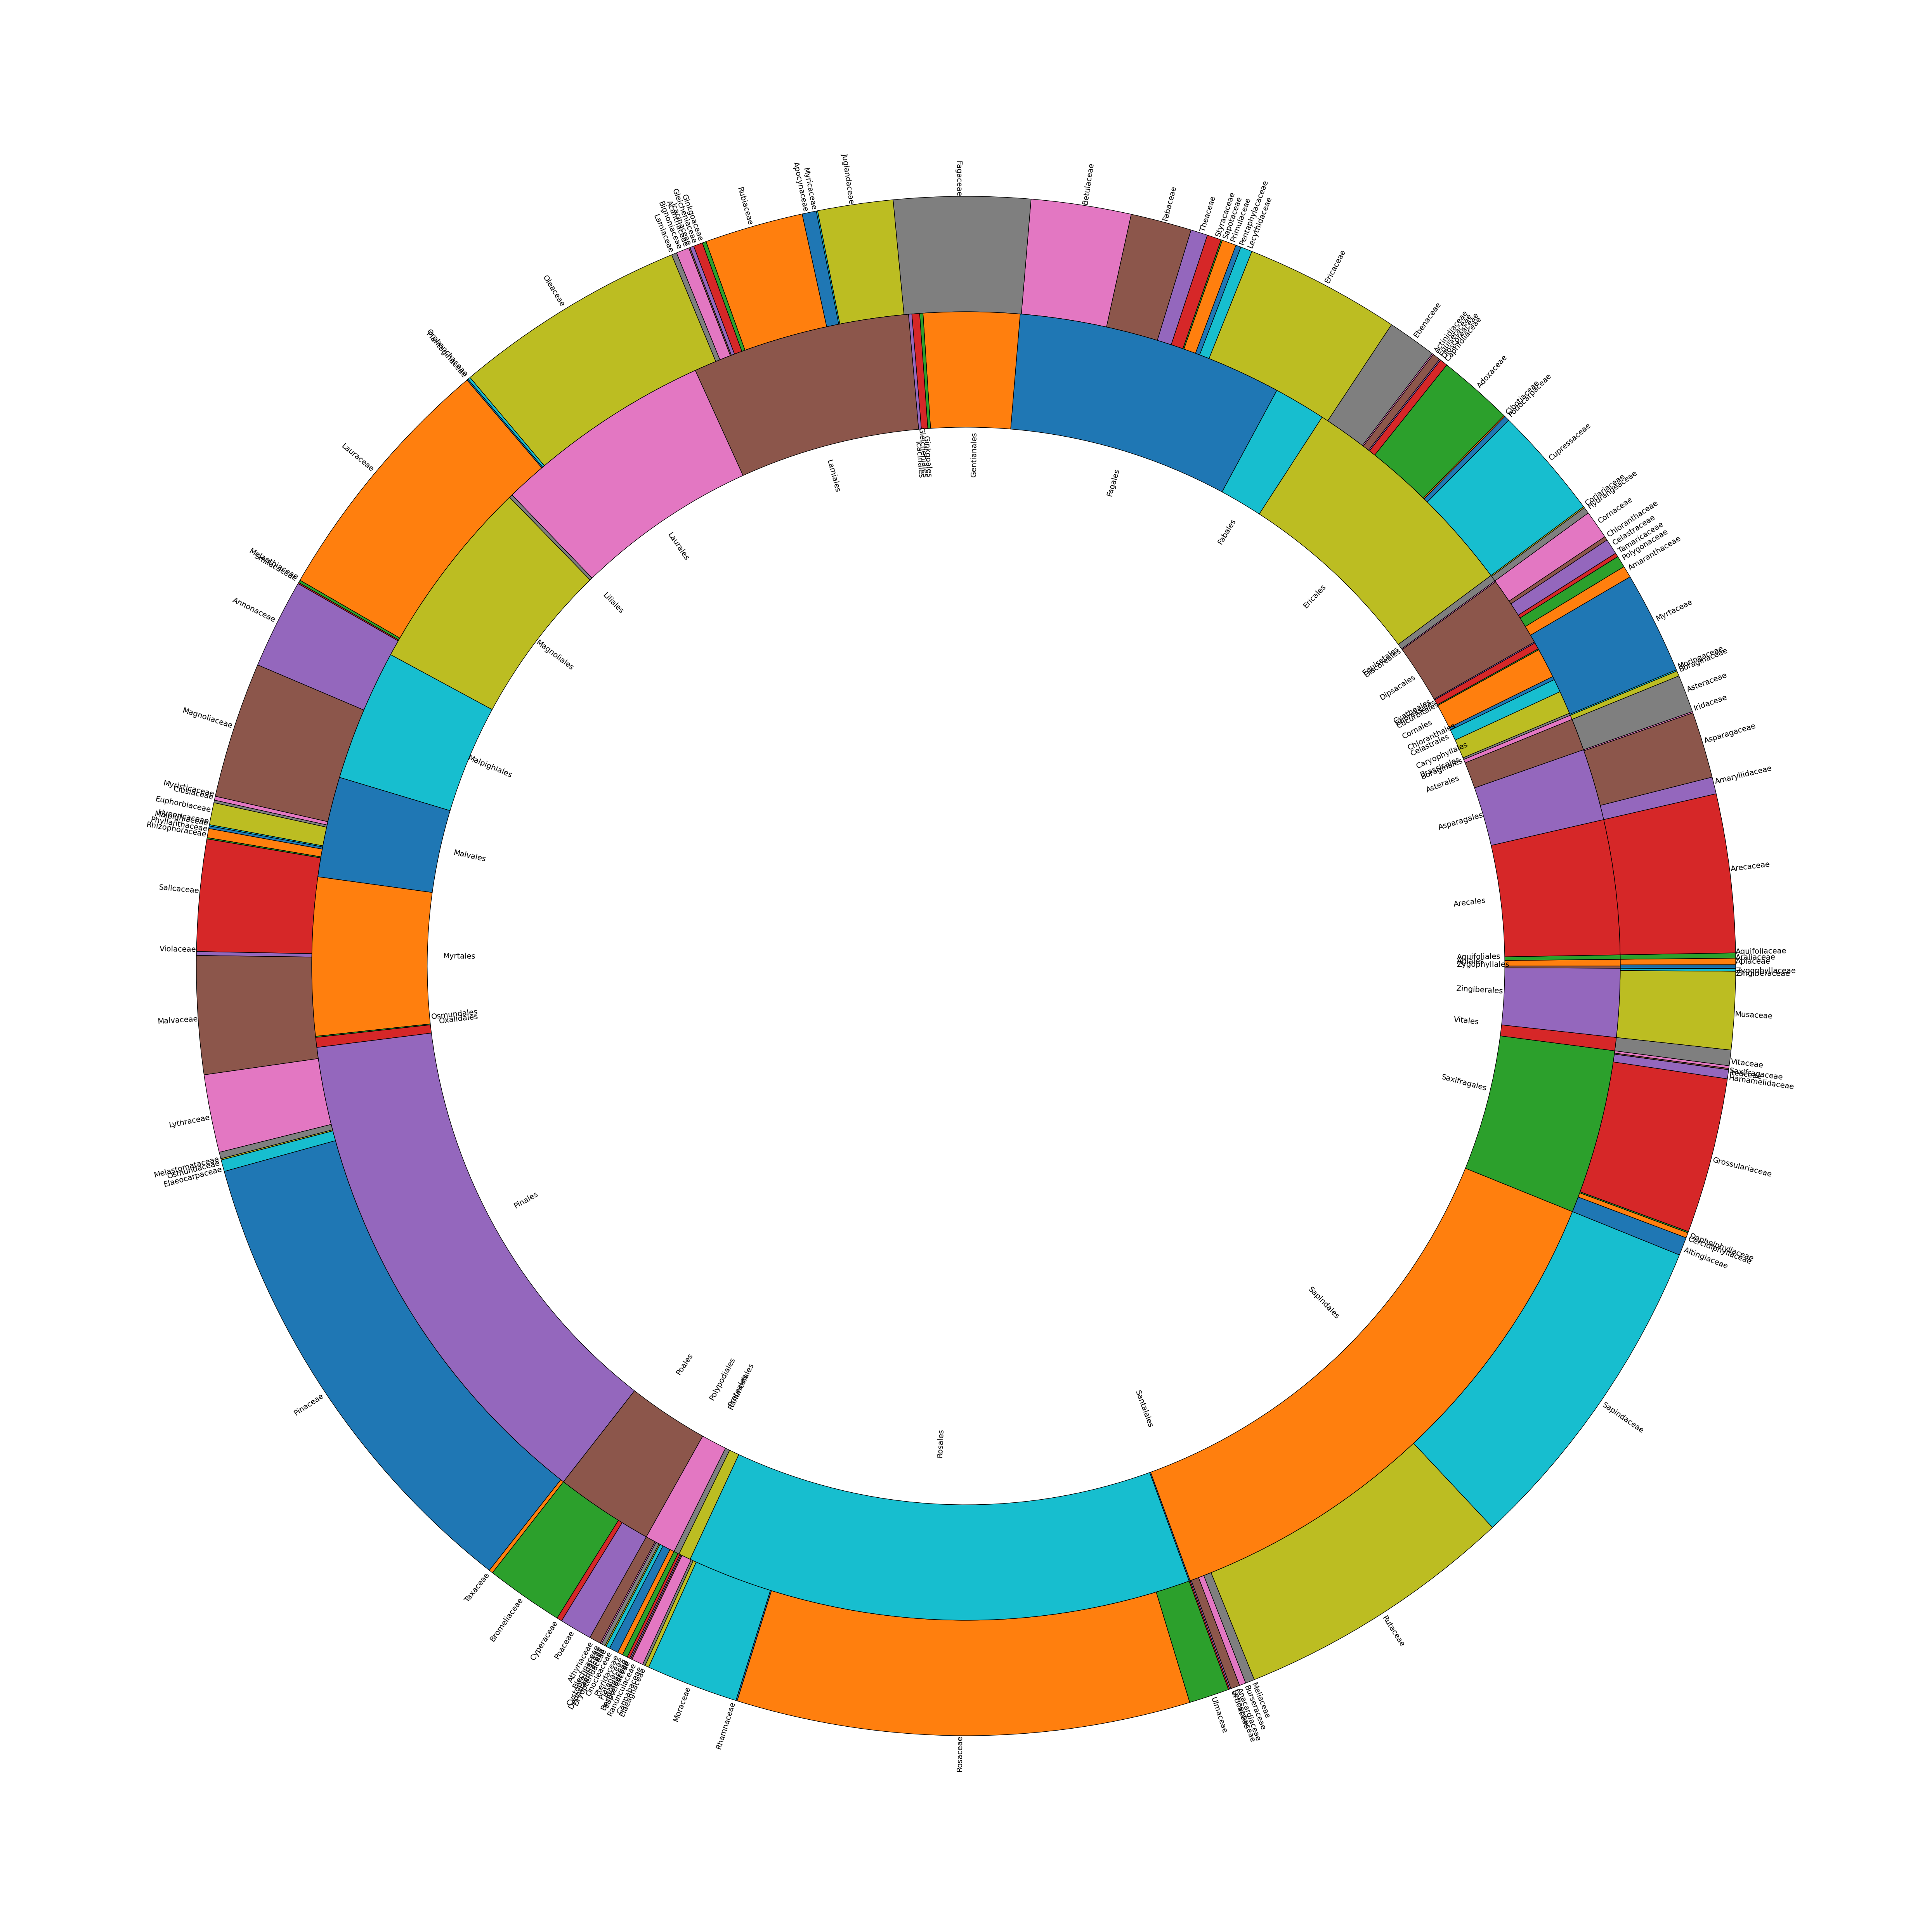

In [53]:
fig, axes = plt.subplots()
fig.set_size_inches(50, 50)
plt.rcParams["font.size"] = 14

RADIUS = 1.00
WIDTH = 0.15
WEDGEPROPERTIES = {
    "width": WIDTH,
    "edgecolor": "black"
}

# family
axes.pie(x=order_preserved_unique_counts(fred_fine_root_diameter_taxonomy.F00017)[1],
         labels=order_preserved_unique_counts(fred_fine_root_diameter_taxonomy.F00017)[0], # autopct='%1.2f%%', pctdistance=0.5,
         labeldistance=1.0, radius=RADIUS, wedgeprops=WEDGEPROPERTIES, rotatelabels=True,
         startangle=0
        )

# order
axes.pie(x=order_preserved_unique_counts(fred_fine_root_diameter_taxonomy.F01290)[1],
         labels=order_preserved_unique_counts(fred_fine_root_diameter_taxonomy.F01290)[0], # autopct='%1.2f%%', pctdistance=0.5,
         labeldistance=0.75, radius=RADIUS-WIDTH, wedgeprops=WEDGEPROPERTIES, rotatelabels=True,
         startangle=0, textprops={"va":"baseline"}
        )

axes.set_aspect("equal")
plt.tight_layout()
# plt.show()
plt.savefig(fname=r"./fred_fineroot_rd_order_family_distribution.jpeg", dpi=500)

## ___Specific Root Length (SRL)___
---------------------

In [111]:
fred_fine_root_specific_root_length = fred.loc[:, ["F00017", "F00018", "F00019", "F00056", "F00727", "F01290"]].\
                                            query("F00056.isin((1, 2, 3))").dropna(subset=["F00018", "F00727"])

# spelling corrections for genus names
fred_fine_root_specific_root_length.F00018 = fred_fine_root_specific_root_length.F00018.apply(lambda genus:\
                                     FRED_MISSPELT_GENERA.get(genus) if\
                                         FRED_MISSPELT_GENERA.get(genus, None) else genus)

# update the families
fred_fine_root_specific_root_length.F00017 = FAMILY_LOOKUP_TABLE[fred_fine_root_specific_root_length.\
                                                    F00018.str.strip()].values

In [114]:
fred_fine_root_specific_root_length.isna().sum() # that's nice

F00017    0
F00018    0
F00019    0
F00056    0
F00727    0
F01290    0
dtype: int64

In [116]:
fred_fine_root_specific_root_length.groupby(["F01290", "F00017", "F00018"]).count()

F00019  F00056  F00727
F01290       F00017        F00018                                 
Apiales      Apiaceae      Sanicula              1       1       1
             Araliaceae    Dendropanax           1       1       1
                           Eleutherococcus       1       1       1
                           Macropanax            1       1       1
                           Schefflera            2       2       2
...                                            ...     ...     ...
Vitales      Vitaceae      Parthenocissus        1       1       1
                           Vitis                 2       2       2
                           Vitis                 9       9       9
Zingiberales Zingiberaceae Alpinia               1       1       1
                           Amomum                1       1       1

[250 rows x 3 columns]

In [214]:
print(
    fred_fine_root_specific_root_length.F01290.unique().size,
    fred_fine_root_specific_root_length.F00017.unique().size,
    fred_fine_root_specific_root_length.F00018.unique().size
)

43 100 246


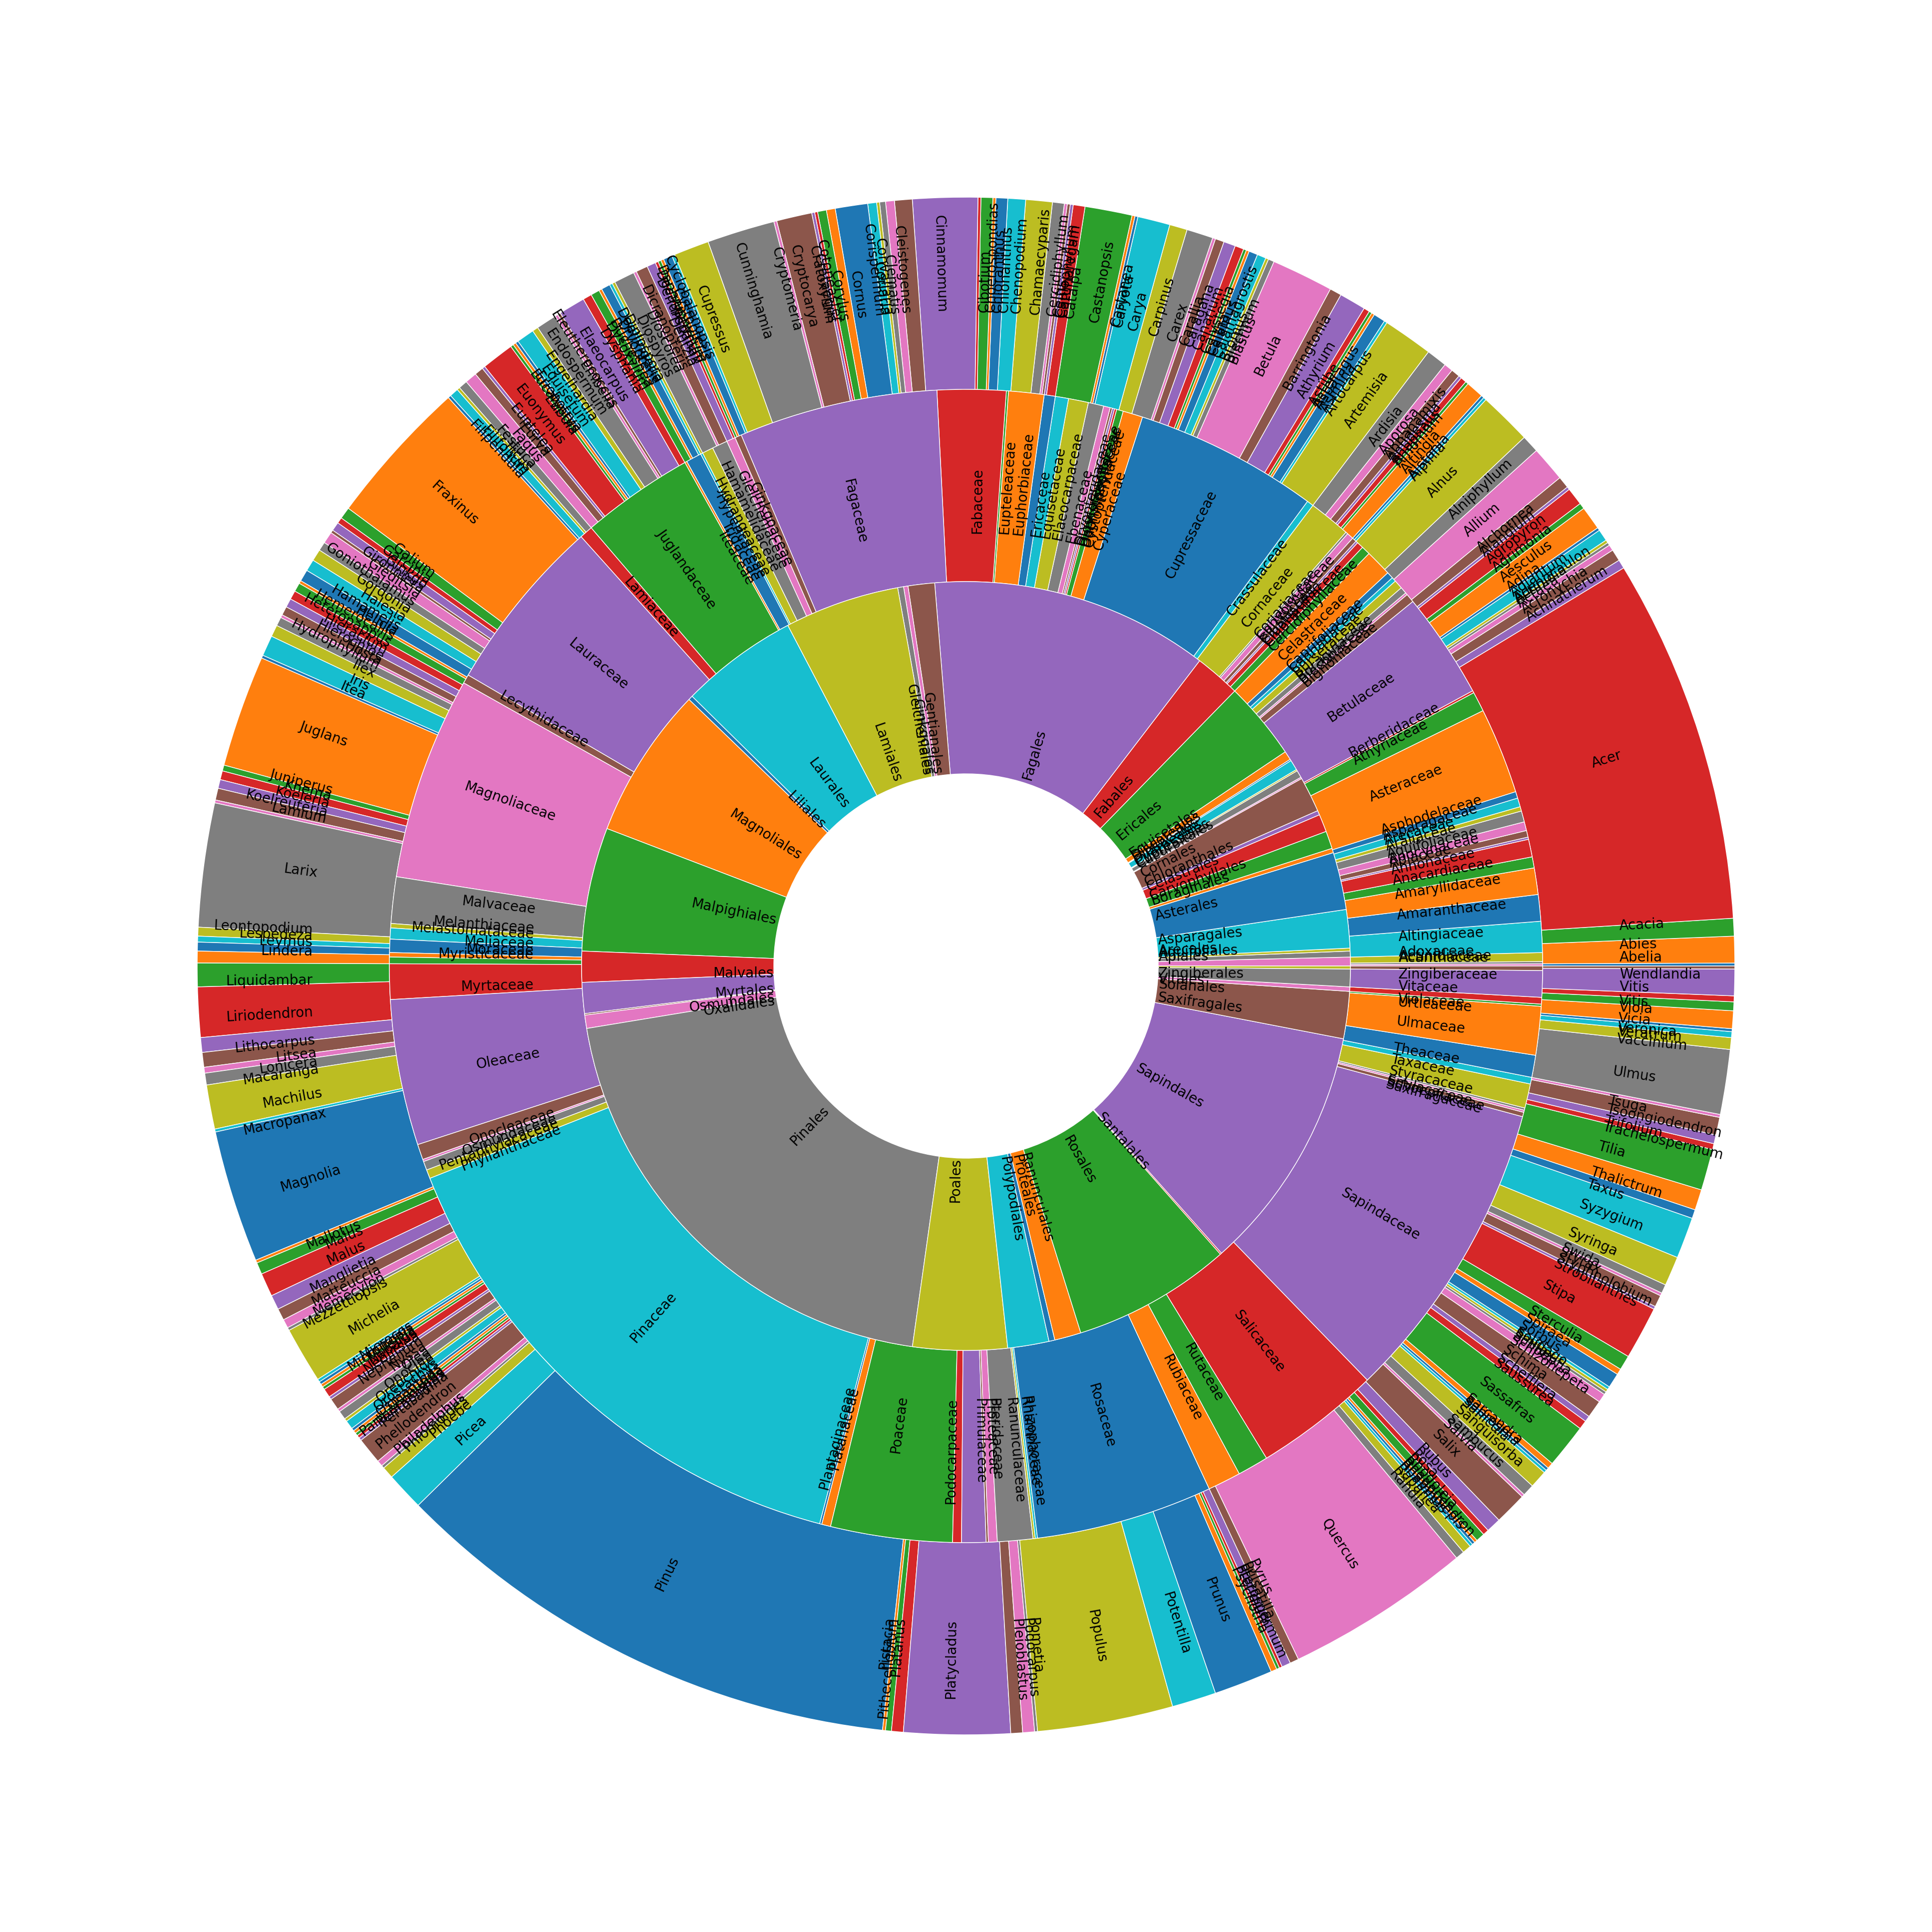

In [263]:
fig, axes = plt.subplots()
fig.set_size_inches(50, 50)
plt.rcParams["font.size"] = 20

RADIUS = 1.00
WIDTH = 0.25
WEDGEPROPERTIES = {
    "width": WIDTH,
    "edgecolor": "white"
}

# genus
axes.pie(x=[df.shape[0] for (_, df) in fred_fine_root_specific_root_length.groupby("F00018")],
         labels=[_ for (_, df) in fred_fine_root_specific_root_length.groupby("F00018")],
         # autopct='%1.2f%%', pctdistance=0.5,
         labeldistance=0.85, radius=RADIUS, wedgeprops=WEDGEPROPERTIES, rotatelabels=True
        )

# family
axes.pie(x=[df.shape[0] for (_, df) in fred_fine_root_specific_root_length.groupby("F00017")],
         labels=[_ for (_, df) in fred_fine_root_specific_root_length.groupby("F00017")],
         # autopct='%1.2f%%', pctdistance=0.5,
         labeldistance=0.75, radius=RADIUS-WIDTH, wedgeprops=WEDGEPROPERTIES, rotatelabels=True
        )

# order
axes.pie(x=[df.shape[0] for (_, df) in fred_fine_root_specific_root_length.groupby("F01290")],
         labels=[_ for (_, df) in fred_fine_root_specific_root_length.groupby("F01290")],
         # autopct='%1.2f%%', pctdistance=0.5,
         labeldistance=0.5, radius=RADIUS-2*WIDTH, wedgeprops=WEDGEPROPERTIES, rotatelabels=True
        )

# axes.set_aspect("equal")
plt.show()